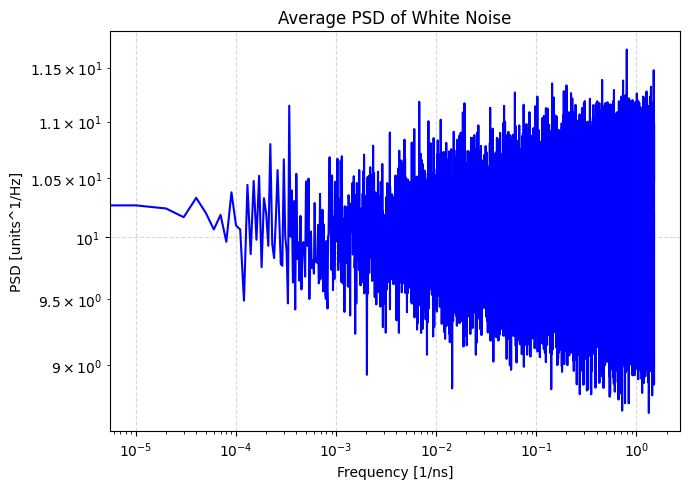

Sanity Checks (white noise):
Median raw periodogram / (S0 * t_max): 0.999557
Std dev of integrated phase / sqrt(S0 * t_max): 0.979009


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import colorednoise as cn


# Function to generate colored noise via Fourier method
def generate_colored_noise(N, T, alpha, fmin = 0.):
    """
    Generate N realizations of 1/f^alpha noise with T samples each.
    Returns array of shape (N, T).
    """
    return np.array([
        cn.powerlaw_psd_gaussian(alpha, T, fmin=fmin)
        for _ in range(N)
    ])

# Parameters
sample_rate = 3               # per ns
t_max = int(1e5)             # number of samples
dt = 1/sample_rate
relative_PSD_strength = (1e-2)**2
num_realizations = 1000
exponent = 0                  # 0 for white noise

# Generate white noise (unit variance) trajectories
N = t_max * sample_rate
trajectories = generate_colored_noise(num_realizations, t*sample_rate, exponent)

# Scale to target PSD at f→0
trajectories *= np.sqrt(relative_PSD_strength * sample_rate)

# Compute raw periodograms
freqs = np.fft.rfftfreq(N, d=dt)
psds = np.abs(np.fft.rfft(trajectories, axis=1))**2 / sample_rate**2

# Average PSD
avg_psd = psds.mean(axis=0)

# Plot average PSD
plt.figure(figsize=(7,5))
plt.loglog(freqs, avg_psd, 'b')
plt.xlabel('Frequency [1/ns]')
plt.ylabel('PSD [units^1/Hz]')
plt.title('Average PSD of White Noise')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Sanity checks
# 1) Median raw periodogram / (S0 * t_max)
median_ratio = np.median(avg_psd) / (relative_PSD_strength * t_max)
# 2) Std dev of integrated phase / sqrt(S0 * t_max)
phi = np.cumsum(trajectories * dt, axis=1)
std_ratio = np.std(phi[:, -1]) / np.sqrt(relative_PSD_strength * t_max)

print('Sanity Checks (white noise):')
print(f"Median raw periodogram / (S0 * t_max): {median_ratio:.6f}")
print(f"Std dev of integrated phase / sqrt(S0 * t_max): {std_ratio:.6f}")

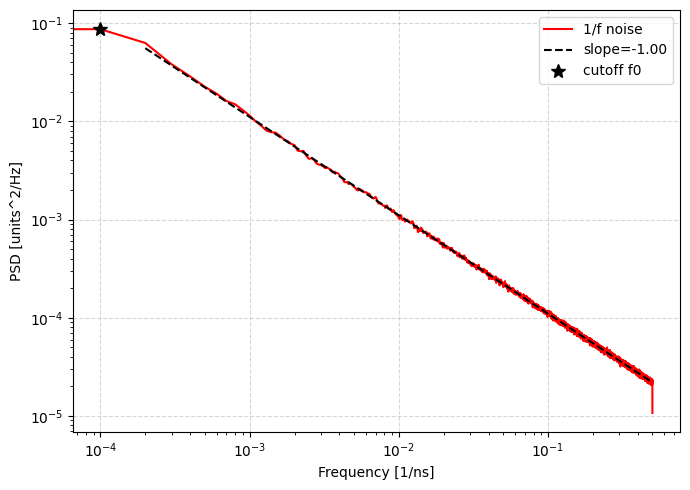

In [11]:


# Set parameters
sample_rate = 1                    # per ns
t_max = int(1e4)                   # number of samples (in ns)
relative_PSD_strength = (1e-2)**2  # desired PSD at zero frequency (units^2/Hz)
f0 = 1e-4                          # low-frequency cutoff for fitting (in ns^-1)
num_realizations = 1000           # Number of Monte-Carlo trajectories
exponent = 1                    # 1/f noise exponent (0 for white noise)   

# 1) Generate unit-variance 1/f noise
t = t_max
trajectories = generate_colored_noise(num_realizations, t*sample_rate, exponent, f0)

# 2) Scale noise so PSD(f→0) = relative_PSD_strength
trajectories *= np.sqrt(relative_PSD_strength*sample_rate)

# 3) Raw periodograms via FFT
t_freq = np.fft.rfftfreq(t, d=1/sample_rate)
psds = np.abs(np.fft.rfft(trajectories, axis=1))**2/sample_rate**2

# 4) Average periodogram
avg_psd = np.mean(psds, axis=0)

# 5) Density PSD fit via Welch
from scipy.signal import welch
nseg = t * sample_rate  # use full length for segment size
f_welch, Pxx_welch = welch(trajectories[0], fs=sample_rate, nperseg=nseg, scaling='density') 
psds_w = np.array([
    welch(y, fs=sample_rate, nperseg=nseg, scaling='density')[1]
    for y in trajectories
])
avg_psd_w = np.mean(psds_w, axis=0)
mask = f_welch > f0
log_f = np.log10(f_welch[mask])
log_P = np.log10(avg_psd_w[mask])
slope, intercept, r_value, p_value, std_err = stats.linregress(log_f, log_P)

# 6) Plot density PSD & fit
plt.figure(figsize=(7,5))
plt.loglog(f_welch, avg_psd_w, 'r', label='1/f noise')
fit_psd = 10**(slope * np.log10(f_welch[mask]) + intercept)
plt.loglog(f_welch[mask], fit_psd, 'k--', label=f'slope={slope:.2f}')
plt.plot(f0, avg_psd_w[np.abs(f_welch-f0).argmin()], 'k*', ms=10, label='cutoff f0')
plt.xlabel('Frequency [1/ns]')
plt.ylabel('PSD [units^2/Hz]')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




In [ ]:
# Set parameters
sample_rate = 1                    # per ns
t_max = int(1e4)                   # number of samples (in ns)
relative_PSD_strength = (1e-2)**2  # desired PSD at zero frequency (units^2/Hz)
f0 = 1e-4                          # low-frequency cutoff for fitting (in ns^-1)
num_realizations = 1000           # Number of Monte-Carlo trajectories
exponent = 1                    # 1/f noise exponent (0 for white noise)   

# 1) Generate unit-variance 1/f noise
t = t_max
trajectories = generate_colored_noise(num_realizations, t*sample_rate, exponent, f0)